In [ ]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.tree as tree
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from IPython.display import display

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
data_raw = pd.read_csv('./data/nshap_w1_w2_w3_core_disposition.csv',
                       low_memory=False)
#Stacking
#SMOTE

## Data cleaning

In [ ]:
data_raw

In [ ]:
# Since the data contains original cohort and follow-up cohort, we need to filter out the follow-up cohort
print("Total observations: {}".format(len(data_raw)))
data_w1 = data_raw[~data_raw['w1WEIGHT_ADJ'].isnull()]
print("Removed follow-up {} respondents without W1 observations".format(len(data_raw) - len(data_w1)))
data_decease = data_w1[data_w1.notnull()].copy()
data_decease['deceased'] = data_decease['w3DECEASED']
data_decease.loc[data_decease['deceased'] == -9, ['deceased']] = np.nan
data_decease['deceased'].fillna(data_decease['w2DECEASED'], inplace=True)
data_decease.loc[data_decease['deceased'] == -9, ['deceased']] = np.nan
data_complete = data_decease[data_decease['deceased'].notnull()]
print("Removed follow-up {} respondents without disposition statuses".format(len(data_w1) - len(data_complete)))
print("Sample frame has {} respondents".format(len(data_complete)))


In [ ]:
data_complete['deceased'].value_counts()

In [ ]:
data = data_complete[['ID', 'deceased', 'w1AGE', 'w1SYSTOLIC_MEAN',
                      'w1BMI', 'w1HBA1C', 'w1CRP', 'w1DHEA_1', 'w1DHEA_2',
                      'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                      'w1EDUC', 'w1HSASSETS_RECODE', 'w1MARITLST', 'w1ETHGRP',
                      'w1GENDER',
                      'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]

In [ ]:
# Preprocessing binary variables,
## 在处理binary和ordinalvariable的时候针对原数据和新数据的处理过程和逻辑，比如str——》0、1
cat_col = ['ID', 'deceased', 'w1SMOKECIG', 'w1ALCOHOL', 'w1MARITLST',
           'w1ETHGRP', 'w1GENDER',
           'w1CONDITNS_3']
##bi_col
data_cat = data[data[cat_col].notnull()].copy()[cat_col]
for col in cat_col:
    data_cat[col] = data_cat[col].astype('category')
data_cat['w1married'] = np.where(data_cat['w1MARITLST'] == 'Married', 1, 0)
data_cat['w1raceblk'] = np.where(data_cat['w1ETHGRP'] == 'Married', 1, 0)
data_cat.drop('w1MARITLST', axis=1, inplace=True)
data_cat.drop('w1ETHGRP', axis=1, inplace=True)

In [ ]:
# Preprocessing ordinal variables
ord_col = ['w1PHYSACT', 'w1EDUC', 'w1HSASSETS_RECODE',
           'w1PHYSHLTH', 'w1MNTLHLTH', 'w1WALKBLK']
data_ord = data[data[ord_col].notnull()].copy()[ord_col]
data_ord[data_ord < 0] = np.nan
data_ord.fillna(data_ord.mean(), inplace=True)

In [ ]:
# Preprocessing continuous variables
con_col = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C',
           'w1CRP', 'w1DHEA_1', 'w1DHEA_2', 'w1HRSSLEEP']
data_con = data[data[con_col].notnull()].copy()[con_col]
for col in con_col:
    data_con[col] = pd.to_numeric(data_con[col], errors='coerce')
data_con['w1dhea_mean'] = data_con[['w1DHEA_1', 'w1DHEA_2']].mean(axis=1)
data_con = data_con.drop(['w1DHEA_1', 'w1DHEA_2'], axis=1)
data_con[data_con < 0] = np.nan
data_con.fillna(data_con.mean(), inplace=True)
data_con.describe()

In [ ]:
data = pd.concat([data_cat, data_ord, data_con], axis=1)
data_nona = data.dropna()
print("Removed {} respondents with missing values in categorical variables".format(len(data) - len(data_nona)))

In [ ]:
data_nona.to_csv("./data/save_df.csv")

In [ ]:
_, ax = plt.subplots(figsize=(6, 6))
columns = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C',
           'w1CRP', 'w1dhea_mean', 'w1HRSSLEEP']
sns.heatmap(data[columns].corr(), annot=True, cmap='RdYlGn', ax=ax);
##加上分析的comment，from heatmap，变量之间的关系是什么样的
##要写comment在上面，每一步代码，口头解释
##直接在Jupyter notbook上写，代码和summary都要呈现在notebook，代码和结果的reaction
##每一步代码的效果和目的注释在notebook上的，参考case study

## Decision Tree

In [ ]:
#减少不同model的variance，是pred更稳定，抵消缺点
#

data_nona = pd.read_csv('./data/save_df.csv')
seed = 42

In [ ]:

data_x = data_nona[['w1AGE', 'w1SYSTOLIC_MEAN',
                    'w1BMI', 'w1HBA1C', 'w1CRP', 'w1dhea_mean',
                    'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                    'w1EDUC', 'w1HSASSETS_RECODE', 'w1married', 'w1raceblk',
                    'w1GENDER',
                    'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]
predictor_names = ['Age', 'Systolic BP', 'BMI', 'HbA1c', 'CRP', 'DHEA',
                   'smoker', 'alcohol', 'physical activity', 'sleep',
                   'education', 'wealth', 'married', 'black race', 'gender',
                   'physical self-rated health', 'mental self-rated health',
                   'chronic conditions', 'walking 1 block']
data_y = data_nona[['deceased']]

# Then split into 60% training, 20% validation, and 20% testing
X_train_v, X_test, y_train_v, y_test = train_test_split(data_x, data_y,
                                                        test_size=0.2,
                                                        random_state=42)
# 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train_v,
                                                  y_train_v,
                                                  test_size=0.25,
                                                  random_state=42)

In [ ]:
# BOTH PRE-PRUNING AND POST_PRUNING (PYTHON PACKAGES TO AUTOMATE THIS PROCESS)
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.01)
DT_clf.fit(X_train, y_train)
# save tree to iris.pdf
dot_data = tree.export_graphviz(DT_clf, out_file=None,
                                feature_names=predictor_names,
                                class_names=['alive', 'deceased'])
display(graphviz.Source(dot_data))
print(metrics.accuracy_score(DT_clf.predict(X_test), y_test))

In [311]:
stk_clfb = Stacking_CLF(n_folds=8, n_esti=20, max_depth=8, seed=42)
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[1.85368373 0.89811378 1.70009929 1.97262101 0.59176895]]
0.8693656093489148
0.7495826377295493


In [312]:
stk_clfb = Stacking_CLF(n_folds=9, n_esti=15, max_depth=3, seed=42)
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[3.02016657 0.70662372 2.60432485 1.32050441 3.23023761]]
0.7658597662771286
0.7529215358931552


In [313]:
stk_clfb = Stacking_CLF(n_folds=10, n_esti=15, max_depth=3, seed=42, weight='balanced')
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[2.49507434 1.7704998  2.81368766 1.17904339 3.23765674]]
0.7199499165275459
0.6894824707846411


In [320]:
print("Best performence at 42", metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))
stk_clfb = Stacking_CLF(n_folds=9, n_esti=18, max_depth=3, seed=42, tr_weight='balanced_subsample')
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

Best performence at 42 0.7479131886477463


/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[1.94462005 1.14903739 2.3467746  1.34681972 3.21516931]]
0.7650250417362271
0.7479131886477463


In [331]:
print("Best performence at 42", metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))
stk_clfb = Stacking_CLF(n_folds=15, n_esti=18, max_depth=3, seed=42, tr_weight='balanced_subsample')
stk_clfb.fit(X_train_v, y_train_v)
print(stk_clfb.get_coeff())
print(metrics.accuracy_score(stk_clfb.predict(X_train_v, proba=False), y_train_v))
print(metrics.accuracy_score(stk_clfb.predict(X_test, proba=False), y_test))

Best performence at 42 0.7495826377295493


/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[1.45292294 1.48676291 2.41081869 1.62534347 3.14304136]]
0.7662771285475793
0.7545909849749582


0.7733423180592991

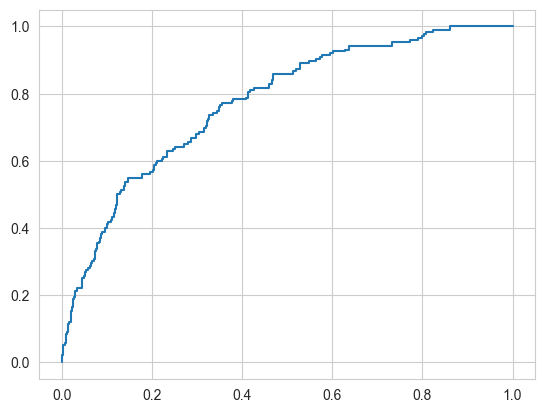

In [332]:
y_prob = stk_clfb.predict(X_test, proba=True)
y_sp = stk_clfb.predict(X_test, proba=False)
fpr, tpr, thr = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
metrics.roc_auc_score(y_test, y_prob)

In [333]:
rf_clusters = stk_clfb.get_clf()
for i, cluster in enumerate(rf_clusters[:4]):

    for j, rf in enumerate(cluster[:-1]):
        print(rf)
        dot_data = tree.export_graphviz(rf.estimators_[0], out_file=None,
                                        filled=True, rounded=True,
                                        special_characters=True,
                                        feature_names=predictor_names,
                                        class_names=['Alive', 'Deceased'])
        graph = graphviz.Source(dot_data)
        graph.render(str(i) + "_nshap0_" + str(j))
        print(i, j)
for i, cluster in enumerate(rf_clusters[:4]):

    for j, rf in enumerate(cluster[:-1]):
        print(rf)
        dot_data = tree.export_graphviz(rf.estimators_[9], out_file=None,
                                        filled=True, rounded=True,
                                        special_characters=True,
                                        feature_names=predictor_names,
                                        class_names=['Alive', 'Deceased'])
        graph = graphviz.Source(dot_data)
        graph.render(str(i) + "_nshap9_" + str(j))
        print(i, j)
for i, cluster in enumerate(rf_clusters[:4]):

    for j, rf in enumerate(cluster[:-1]):
        print(rf)
        dot_data = tree.export_graphviz(rf.estimators_[17], out_file=None,
                                        filled=True, rounded=True,
                                        special_characters=True,
                                        feature_names=predictor_names,
                                        class_names=['Alive', 'Deceased'])
        graph = graphviz.Source(dot_data)
        graph.render(str(i) + "_nshap17_" + str(j))
        print(i, j)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=3, n_estimators=18, n_jobs=-1,
                       random_state=42)
0 0
RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       n_estimators=18, n_jobs=-1, random_state=43)
0 1
ExtraTreesClassifier(class_weight='balanced_subsample', criterion='entropy',
                     max_depth=3, n_estimators=18, n_jobs=-1, random_state=44)
0 2
ExtraTreesClassifier(class_weight='balanced_subsample', max_depth=3,
                     n_estimators=18, n_jobs=-1, random_state=45)
0 3
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=3, n_estimators=18, n_jobs=-1,
                       random_state=42)
1 0
RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       n_estimators=18, n_jobs=-1, random_state=43)
1 1
ExtraTreesClassifier(class_weight='balanc

In [334]:
X_test.columns = predictor_names

In [352]:
y_sp = np.array(y_sp)
gt = list(dict(y_test)['deceased'])
gt = np.array(gt)
f_idx = np.reshape(np.argwhere(y_sp != gt), [-1])
X_wrong = X_test.iloc[f_idx]
X_wrong['deceased'] = y_sp[f_idx]
X_wrong

/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_36672/1112926933.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_wrong['deceased']=y_sp[f_idx]


,Age,Systolic BP,BMI,HbA1c,CRP,DHEA,smoker,alcohol,physical activity,sleep,education,wealth,married,black race,gender,physical self-rated health,mental self-rated health,chronic conditions,walking 1 block,deceased
1374,4.771983,2.971285,0.742092,0.783655,0.678735,-0.202921,10.000000,-12.434457,-22.262118,3.477911,-3.281596,2.675545,NaN,NaN,-11.546763,-0.887143,10.000000,-1.519231,-1.783607,1.0
2110,2.811477,-0.639799,-0.338796,0.048748,-0.011860,-0.144557,-1.519231,-12.434457,10.000000,3.477911,-9.922395,0.108414,NaN,NaN,10.000000,-6.330715,-5.834772,-1.519231,2.144262,1.0
2097,5.425485,2.584383,-0.778440,0.048748,-0.011860,0.031709,-1.519231,-12.434457,10.000000,-1.413655,-3.281596,0.108414,NaN,NaN,10.000000,-0.887143,2.082614,-1.519231,-1.783607,0.0
1017,-0.456033,-3.992947,0.000312,-0.825548,-0.262203,0.031709,-1.519231,-12.434457,-22.262118,1.847389,-3.281596,0.108414,NaN,NaN,-11.546763,-6.330715,-13.752159,-1.519231,-1.783607,0.0
144,-8.298058,4.712343,-0.959499,0.637364,-0.159297,3.327560,-1.519231,-12.434457,10.000000,-3.044177,3.359202,-19.297822,NaN,NaN,10.000000,-6.330715,2.082614,10.000000,2.144262,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,-1.763037,-1.155668,0.770493,0.048748,0.249015,0.304526,-1.519231,10.000000,10.000000,-3.044177,-9.922395,0.108414,NaN,NaN,10.000000,-11.774286,-5.834772,10.000000,2.144262,0.0
2582,-5.684050,-1.349118,5.551726,-0.240383,3.613039,-0.800776,-1.519231,-12.434457,-11.508079,1.847389,-9.922395,2.675545,NaN,NaN,-11.546763,-6.330715,-5.834772,-1.519231,10.000000,0.0
2225,-6.337552,0.087349,-0.075851,0.048748,-0.011860,0.031709,10.000000,-12.434457,10.000000,1.847389,-3.281596,0.108414,NaN,NaN,-11.546763,-6.330715,2.082614,-1.519231,2.144262,0.0
1023,5.425485,-0.962217,-1.553920,-1.410713,-0.040051,-0.418260,-1.519231,10.000000,10.000000,1.847389,-9.922395,2.675545,NaN,NaN,-11.546763,-0.887143,10.000000,-1.519231,-1.783607,0.0


In [337]:
s_idx = np.reshape(np.argwhere(y_sp == gt), [-1])
X_right = X_test.iloc[s_idx]
X_right['deceased'] = y_sp[s_idx]
X_right

/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_36672/1822508282.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_right['deceased']=y_sp[s_idx]


,Age,Systolic BP,BMI,HbA1c,CRP,DHEA,smoker,alcohol,physical activity,sleep,education,wealth,married,black race,gender,physical self-rated health,mental self-rated health,chronic conditions,walking 1 block,deceased
321,59.0,148.0,28.500000,6.097641,3.19458,56.285000,0.0,0.0,3.0,6.0,1.0,3.649512,0,0,1.0,3.0,4.0,0.0,0.0,0.0
1578,73.0,152.0,30.417559,5.400000,5.46500,127.855000,0.0,1.0,4.0,9.0,4.0,3.649512,0,0,1.0,4.0,4.0,0.0,0.0,0.0
178,75.0,103.5,30.056837,6.097641,1.14300,27.895000,0.0,1.0,4.0,8.0,2.0,4.000000,0,0,1.0,3.0,3.0,0.0,0.0,0.0
495,68.0,107.0,30.712875,5.500000,3.17500,142.695000,0.0,1.0,4.0,8.0,1.0,3.000000,0,0,1.0,2.0,3.0,0.0,1.0,0.0
471,67.0,152.5,23.289228,6.097641,3.19458,52.921454,0.0,1.0,4.0,8.0,2.0,3.649512,0,0,1.0,5.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,63.0,143.5,34.942013,5.600000,2.86800,59.215000,0.0,0.0,3.0,5.0,3.0,2.000000,0,0,2.0,4.0,4.0,0.0,0.0,0.0
2337,62.0,146.5,36.540760,6.000000,8.94300,52.921454,0.0,1.0,4.0,6.0,1.0,3.649512,0,0,1.0,3.0,3.0,0.0,0.0,0.0
1192,74.0,124.0,30.550123,6.097641,1.96900,7.330000,0.0,0.0,4.0,6.0,2.0,2.000000,0,0,2.0,4.0,4.0,0.0,0.0,0.0
226,73.0,124.0,26.356962,6.900000,1.96100,48.695000,0.0,0.0,0.0,7.0,2.0,5.000000,0,0,1.0,1.0,5.0,0.0,0.0,1.0


In [ ]:
# tsne降维可视化
# 讨论stacking的实现细节

In [349]:
X_test_new = X_test
for idx in list(X_test_new.columns):
    X_test_new[idx] = (X_test_new[idx] - X_test_new[idx].mean()) / (X_test_new[idx].max() - X_test_new[idx].mean()) * 10
X_test_new = X_test_new.drop(columns=['married', 'black race'])

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


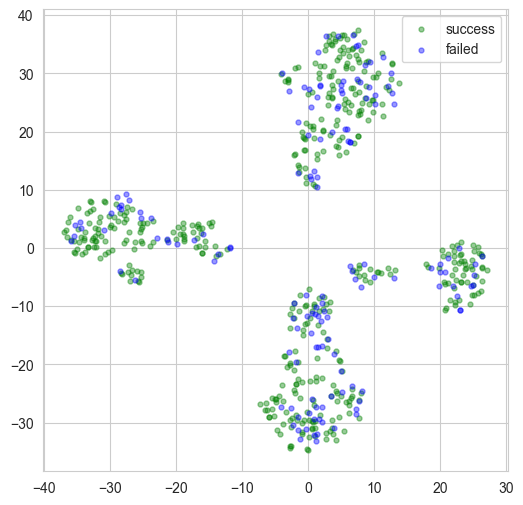

In [354]:

x_train = np.array(X_test_new)
x_tsne = TSNE(n_components=2, learning_rate=100, random_state=501).fit_transform(x_train)

plt.figure(figsize=(6, 6))
r = 2  # 4ls

area = np.pi * r ** 2  # 点面积

plt.scatter(x_tsne[s_idx, 0], x_tsne[s_idx, 1], s=area, c='g', alpha=0.4, label='success')
plt.scatter(x_tsne[f_idx, 0], x_tsne[f_idx, 1], s=area, c='b', alpha=0.4, label='failed')
plt.legend()
#plt.savefig(name)
plt.show()

In [ ]:
#onehot
#validation
#model performence interpretation
#wrong sample

##decision tree classifier,
##根据observation在develop下一步改变